# **SEC Financial Statement Report Analysis**

### Working with Big Data - Group 12

### Team Members: Laura Le, Jennifer Nguyen, Vibhu Verma, Sally Zhang

The dataset we picked for the project is SEC Financial Statement Dataset. The SEC Financial Statement Dataset provides the text and detailed numeric information of all financial statements. The Dataset is extracted from corporate annual and quarterly reports filed with the SEC using XBRL since January 2009. The dataset covers all XBRL filings since 2009, it includes 12.6k companies. In total 239.7k annual and quarterly reports, 192.5 million data points, and 20GB+ compressed in Parquet.

First, let's connect to the all the documents and have a heads up of all the tables.

In [1]:
import findspark
findspark.init()

In [2]:
from pyspark import SparkContext

In [3]:
sc = SparkContext()

In [4]:
sc

<SparkContext master=yarn appName=pyspark-shell>

In [7]:
#sqlContext = pyspark.SQLContext(sc)

In [4]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

In [5]:
spark

In [6]:
!pip install pyspark_dist_explore

In [7]:
import pyspark
import pandas as pd
import numpy as np
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from IPython.display import display, HTML, display_html #usefull to display wide tables
from pyspark_dist_explore import Histogram, hist, distplot, pandas_histogram
from pyspark.sql import Row

%matplotlib inline

In [12]:
#!pip uninstall pyarrow -y

Found existing installation: pyarrow 0.17.1
Uninstalling pyarrow-0.17.1:
  Successfully uninstalled pyarrow-0.17.1


In [13]:
#!pip install pyarrow

  Using cached pyarrow-0.17.1-cp37-cp37m-manylinux2014_x86_64.whl (63.8 MB)


## **Create Dataframes in Spark**

Load all the tables from S3 buckets

### 1. Company Submission Table

In [8]:
company_submission = spark.read.csv("s3://big-data-project-sec/company_submission.csv",header=True,inferSchema=True)

In [25]:
company_submission.show()

+--------------------+--------------------+----+--------------------+-------------------+-------------+------------------------+----------------------------+--------------------------+----------------------------+-----------------------------+--------------+------------+----------+----------------------+-----------------------+-----------------------+--------------------+---------------------+-------------------+------------------------+------------------------+---------------------+----------------------+--------------------+--------------------+---------------------+
|accession_number_int|    accession_number| cik|        company_name|        filing_date|document_type|document_period_end_date|current_fiscal_year_end_date|document_fiscal_year_focus|document_fiscal_period_focus|current_fiscal_year_end_month|amendment_flag|assigned_sic|irs_number|state_of_incorporation|mailing_address_street1|mailing_address_street2|mailing_address_city|mailing_address_state|mailing_address_zip|business

### 2. Data Point Table

In [27]:
data_point = spark.read.csv("s3://big-data-project-sec/data_point.csv",header=True,inferSchema=True)

In [11]:
data_point.show()

+-------+--------------------+-------------------+------------+--------------------+------------+--------------------+--------------------+----------+----------+------------+------------+-------------+--------+------+--------------------+
|    cik|accession_number_int|        filing_date|datapoint_id|      datapoint_name|     version|       segment_label|        segment_hash|start_date|  end_date|period_month|string_value|numeric_value|decimals|  unit|           footnotes|
+-------+--------------------+-------------------+------------+--------------------+------------+--------------------+--------------------+----------+----------+------------+------------+-------------+--------+------+--------------------+
|1116521|     111652115000023|2015-05-08 00:00:00|   518033296|RetainedEarningsA...|us-gaap/2014|                null|                null|      null|2014-09-30|        null| -4831000000|     -4.831E9|      -6|   USD|                null|
|1116521|     111652115000023|2015-05-08 00:

### 3. Data Point Revision Table

In [28]:
data_point_revision = spark.read.csv("s3://bigdata-dataset/data_point_revision.csv",header=True,inferSchema=True)

In [11]:
data_point_revision.show()

+------------+--------------------+-------------------+------------+-------------+
|datapoint_id|accession_number_int|        filing_date|string_value|numeric_value|
+------------+--------------------+-------------------+------------+-------------+
|   989302759|     156459017016031|2017-08-07 00:00:00|   -94000000|       -9.4E7|
|  1047640187|     116965217000014|2017-02-16 00:00:00|     1259000|    1259000.0|
|   576680812|     119312514298325|2014-08-06 00:00:00|      0.1026|       0.1026|
|   462333128|     119312511030543|2011-02-10 00:00:00|  2225000000|      2.225E9|
|    48056163|     119312511215824|2011-08-09 00:00:00|       -4.70|         -4.7|
|  1050362060|       2678018000015|2018-10-29 00:00:00|   125000000|       1.25E8|
|  1050362060|       2678018000012|2018-07-25 00:00:00|    87000000|        8.7E7|
|     1297262|     104746911010161|2011-12-21 00:00:00|   127659000|    1.27659E8|
|   837494081|     103703816000019|2016-05-19 00:00:00|   114000000|       1.14E8|
|   

### 4. Data Point Snapshot Table

In [29]:
data_point_snapshot = spark.read.csv("s3://avecsallybigdata/SEC/Unsaved/2020/06/22/data_point_snapshot.csv",header=True,inferSchema=True)

In [13]:
data_point_snapshot.show()

+-------+--------------------+-------------------+------------+--------------------+------------+--------------------+--------------------+----------+----------+------------+------------+-------------+--------+----+---------+------------+
|    cik|accession_number_int|        filing_date|datapoint_id|      datapoint_name|     version|       segment_label|        segment_hash|start_date|  end_date|period_month|string_value|numeric_value|decimals|unit|footnotes|revision_num|
+-------+--------------------+-------------------+------------+--------------------+------------+--------------------+--------------------+----------+----------+------------+------------+-------------+--------+----+---------+------------+
|1488638|     112178113000441|2013-11-19 00:00:00|   245895145|IncomeTaxExpenseB...|us-gaap/2012|                null|                null|2012-01-01|2012-09-30|           9|           0|          0.0|       0| USD|     null|        null|
| 773318|     160706215000369|2015-08-18 00:

#### 5. Report Presentation Line Item

In [14]:
report_presentation_line_item = spark.read.csv("s3://avecsallybigdata/SEC/Unsaved/2020/06/22/property.csv",header=True,inferSchema=True)

In [15]:
report_presentation_line_item.show()

+--------------------+-------------------+------------------+---------------------+--------------------+--------------------+--------------------+------------+
|accession_number_int|section_sequence_id|line_item_sequence|parent_datapoint_name|      datapoint_name|preferred_label_role|     datapoint_label|datapoint_id|
+--------------------+-------------------+------------------+---------------------+--------------------+--------------------+--------------------+------------+
|     134131819000039|                  6|                15|   StatementLineItems|NewAccountingPron...|          terseLabel|Cumulative effect...|  1163633296|
|       2841212000031|                 60|                13| ScheduleOfBusines...|  StatementLineItems|          terseLabel|Statement [Line I...|        null|
|     162836919000019|                 37|                 7| SegmentReportingA...|AllocatedSharebas...|          terseLabel|Cassidy Turley de...|  1132113186|
|     162836919000019|                 3

#### 6. Report Presentation Section Table

In [9]:
report_presentation_section = spark.read.csv("s3://bigdata-dataset/report_presentation_section.csv",header=True,inferSchema=True)

In [31]:
report_presentation_section.show()

+------+-------------------+--------------------+-------------------+--------------+--------------------------+
|   cik|        filing_date|accession_number_int|section_sequence_id|statement_type|report_section_description|
+------+-------------------+--------------------+-------------------+--------------+--------------------------+
|356028|2017-05-12 00:00:00|      35602817000047|                 26|          null|      Disclosure - Valu...|
|356028|2017-05-12 00:00:00|      35602817000047|                 92|          null|      Disclosure - Supp...|
|914208|2012-11-01 00:00:00|      91420812000539|                 11|          null|         Disclosure - Debt|
|914208|2012-11-01 00:00:00|      91420812000539|                 25|          null|      Disclosure - Debt...|
|914208|2012-11-01 00:00:00|      91420812000539|                 28|          null|      Disclosure - Reti...|
|914208|2012-11-01 00:00:00|      91420812000539|                 32|          null|      Disclosure - R

#### 7. Segment

In [18]:
segment = spark.read.csv("s3://bigdata-dataset/segment.csv",header=True,inferSchema=True)

In [19]:
segment.show()

+--------------------+--------------------+
|        segment_hash|             segment|
+--------------------+--------------------+
|02ab5900-a66d-779...|DerivativeInstrum...|
|b5c71385-e3a8-f8b...|FiniteLivedIntang...|
|2e216841-e8dd-c81...|RelatedPartyTrans...|
|8850327f-c51c-510...|CashCashEquivalen...|
|bbffc654-d6b3-34d...|FinancingReceivab...|
|57a12b46-9248-34f...|ProductOrService=...|
|faa580ac-c131-781...|AwardType=Employe...|
|04c7e9f9-4f3c-109...|RealEstateAgreeme...|
|2bb20be1-e40b-39d...|ConcentrationRisk...|
|c5713a36-51ad-fff...|ConcentrationRisk...|
|2f74e72d-9506-cd4...|ConcentrationRisk...|
|ec766c81-589d-937...|CreditFacility=Re...|
|382f5e6c-9cd0-5d8...|LiabilitiesArisin...|
|460b7f42-c8fd-4bf...|ScheduleOfShareBa...|
|ff93ebe4-4bd7-490...|FairValueByBalanc...|
|37e83486-5e34-5fe...|FiniteLivedIntang...|
|c7d498c9-8246-80b...|DeferredRevenueAr...|
|b6573d0c-fb59-456...|StatementGeograph...|
|2929af9c-4b7d-f78...|StatementBusiness...|
|291ef1f0-ff88-3f9...|FairValueB

#### Install dist plot package


#Install from PyPi:


#pip install pyspark_dist_explore

#Or directly from github:

#git clone https://github.com/Bergvca/pyspark_dist_explore.git
#cd pyspark_dist_explore
#pip install .

## **Explanatory Data Analysis**

The 7 tables contains numerous information of the company filling data. And by taking some explanatory analysis to our data will help us gain some insights. 

We are very interested to see the resutls of the following questions: 

1. What are the top 10 states that have the highest number of public companies over the past years? 

2. What are the top 20 report sections that appear the most in 10Ks and 10Qs and which statement do they belong to?

3. What is the distribution of companies based on fiscal year end month?

4. What are the top 10 companies that have the highest current assets in 2018?

5. Annual reports of top 5 companies in above list from 2010-02-25 to 2019-02-22?

### **1.  Most Popular States for Public Companies**

In [22]:
company_submission.createOrReplaceTempView("company_submission")

file_type = spark.sql("""SELECT document_type, business_address_state
FROM company_submission
WHERE document_type LIKE '%10-K%' 
""").cache()

In [23]:
file_type.show(10)

+-------------+----------------------+
|document_type|business_address_state|
+-------------+----------------------+
|         10-K|                    PA|
|         10-K|                    TX|
|         10-K|                    NY|
|         10-K|                    WI|
|         10-K|                    IL|
|         10-K|                    CT|
|         10-K|                    SD|
|         10-K|                    IL|
|         10-K|                    TX|
|         10-K|                    FL|
+-------------+----------------------+
only showing top 10 rows



In [24]:
file_type.createOrReplaceTempView("file_type")

top_company_states = spark.sql("""SELECT business_address_state, COUNT(business_address_state)AS Frequency
FROM file_type
GROUP BY business_address_state
ORDER BY
COUNT(business_address_state) DESC
limit 10""").cache()

In [25]:
top_company_states.show(10)

+----------------------+---------+
|business_address_state|Frequency|
+----------------------+---------+
|                    CA|     8851|
|                    NY|     5519|
|                    TX|     5066|
|                    FL|     3008|
|                    MA|     2238|
|                    NJ|     2106|
|                    PA|     2037|
|                    IL|     1883|
|                    CO|     1684|
|                    NV|     1619|
+----------------------+---------+



In [26]:
company_submission.select('business_address_state').distinct().count()

175

In [ ]:
# Convert to Pandas DataFrame  
df_pandas = top_company_states.toPandas()

# Create a horizontal bar plot
df_pandas.plot(kind='barh', x='business_address_state', y='Frequency', colormap='tab20c')
plt.xlabel('Count of Annual Report Filings')
plt.ylabel('Business States')
plt.title('Top 10 Company Business Sates')
plt.show()

In [ ]:
spark.conf.set("spark.sql.execution.arrow.enabled", "true")
df_pandas = top_company_states.toPandas()

Text(0.5, 1.0, 'Top 10 Company Business Sates')

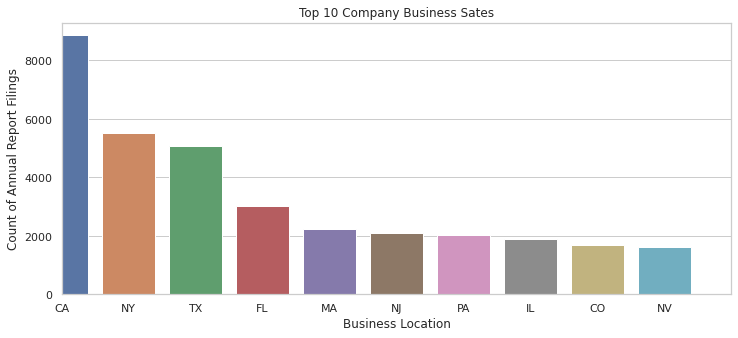

In [47]:
sns.set(style="whitegrid")
sns.set_color_codes("pastel")
f, ax = plt.subplots(figsize=(12, 5))
ax=sns.barplot(x = "business_address_state", y = "Frequency", data = df_pandas)


ax.set(xlim=(0, 10), ylabel="Count of Annual Report Filings", xlabel="Business Location")
plt.title('Top 10 Company Business Sates')

In [2]:
#!pip install update PyArrow #this is to support matplotlib 

### **2. What are the top 20 report sections that appear the most across 10Ks and 10Qs and which statement do they belong to?**

In [15]:
report_presentation_section.createOrReplaceTempView("report_presentation_section")

unique_section = spark.sql("""SELECT count(distinct report_section_description)
FROM report_presentation_section
""").cache()

In [33]:
unique_section.show()

+------------------------------------------+
|count(DISTINCT report_section_description)|
+------------------------------------------+
|                                   1170159|
+------------------------------------------+



There are 1170159 distinct report sections that exist across the submitted financial reports. This large number can be explained by the variation in naming a standard section. For example, Balance Sheet can be listed as `Balance Sheet` or `Consolidated Balance Sheet`.

Now, let's see which sections are the most common across reports.The higher the frequency of appearance a section has, the more important they might be to financial reporting overall.

In [16]:
most_used_section_overall = spark.sql("""SELECT report_section_description, statement_type, count (report_section_description) as Frequency
FROM report_presentation_section
group by report_section_description, statement_type
order by count (report_section_description) desc
""").cache()


In [17]:
most_used_section_overall.show(20, False)

+------------------------------------------------------------------+--------------+---------+
|report_section_description                                        |statement_type|Frequency|
+------------------------------------------------------------------+--------------+---------+
|Document - Document and Entity Information                        |null          |177864   |
|Disclosure - Income Taxes                                         |null          |90293    |
|Disclosure - Commitments and Contingencies                        |null          |76382    |
|Disclosure - Subsequent Events                                    |null          |59427    |
|Statement - Consolidated Balance Sheets                           |B             |56226    |
|Disclosure - Summary of Significant Accounting Policies           |null          |53734    |
|Disclosure - Fair Value Measurements                              |null          |48811    |
|Statement - Consolidated Balance Sheets (Parenthetical)    

* As we can see from the results above, `Document and Entity Information` is the most common section. This is expected since almost every single financial report will have a section to introduce the company and the purpose of the report. The second most common section in a financial report is `Disclosure - Income Taxes`. Therefore, this may imply that besides the section that includes an introduction of the entity and the purpose of the report, `Income Taxes`, `Commitments and Contingencies`, and `Subsequent Events` are the most essential sections in a report. Within this top 20, the sections that have `Disclosure` in their names give us some clues about the information that investors most care about regarding reporting transparency. 

* From this top 20, we can also see the most essential/important financial statements. They are Balance Sheet and Statement of Cash Flows, with Balance Sheet ranking higher in the level of importance. (We can see under `statement_type` column, B and BP appear 4 times, with a total section frequency of 161K+ times while C only appears once with a section frequency of 42851 times.)

In [16]:
#!conda install -c conda-forge pyarrow

In [17]:
#!pip install pyarrow

In [ ]:
# Convert to Pandas DataFrame  
df_pandas_2 = most_used_section_overall.toPandas()

plot = df_pandas_2[['report_section_description','Frequency' ]].plot(kind = 'bar', x='report_section_description', y='Frequency', legend = None)
plt.ylabel('Frequency of Appearance', fontsize = 15)
plot.set_xticklabels(plot.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize = 15)
plt.title('Top 20 Most Common Report Sections', fontsize = 20)


# change the size of the the plot
fig = plt.gcf()
fig.set_size_inches(15, 7)

plt.show()

In [19]:
df_pandas_2 = most_used_section_overall.toPandas()
df_pandas_2

,report_section_description,statement_type,Frequency
0,Document - Document and Entity Information,None,177864
1,Disclosure - Income Taxes,None,90293
2,Disclosure - Commitments and Contingencies,None,76382
3,Disclosure - Subsequent Events,None,59427
4,Statement - Consolidated Balance Sheets,B,56226
...,...,...,...
1170490,"Disclosure - Property, Plant and Equipment (Ta...",None,1
1170491,Disclosure - Share-Based Compensation Deferred...,None,1
1170492,Disclosure - Employee Benefit Plans (Summary O...,None,1
1170493,Disclosure - Segments Reporting (Details Textual),None,1


### **3. What is the distribution of companies based on fiscal year end month?**

* `Fiscal_year_end_month` is the indicator of the end of a business operations cycle for each type of business or industry. For example, if the company is in the retail business, then it is reasonable to set a fiscal year end date after the Holiday season (probably December 30th). While for a pooling service company, for example, the business cycle ends at the end of the summer. Thus, it would be reasonable for the company to set the fiscal year end date on September 30th. 
* The distribution of companies across months will present insights into what business cycles are the most prominent across 12.6K+ companies that submitted financial filings to the SEC over the last 10 years.

In [ ]:
fy_end_month = spark.sql("""select current_fiscal_year_end_month, count(distinct company_name) as Number_of_Companies
from (select * from company_submission where current_fiscal_year_end_month is not null and current_fiscal_year_end_month != 0)
group by current_fiscal_year_end_month order by current_fiscal_year_end_month
""").cache()

In [14]:
fy_end_month.show()

+-----------------------------+-------------------+
|current_fiscal_year_end_month|Number_of_Companies|
+-----------------------------+-------------------+
|                            1|                410|
|                            2|                235|
|                            3|               1003|
|                            4|                296|
|                            5|                270|
|                            6|               1054|
|                            7|                273|
|                            8|                304|
|                            9|                926|
|                           10|                314|
|                           11|                224|
|                           12|              11644|
+-----------------------------+-------------------+



In [15]:
# Convert to Pandas DataFrame  
df_pandas_3 = fy_end_month.toPandas()

plot = df_pandas_3.plot(kind = 'bar', x='current_fiscal_year_end_month', y='Number_of_Companies', legend = None)
plt.ylabel('Number of Companies', fontsize = 15)
plot.xlabel('Month', fontsize = 15)
plt.title('Distribution of Companies based on FY End Month', fontsize = 20)


# change the size of the the plot
fig = plt.gcf()
fig.set_size_inches(15, 7)

plt.show()

/usr/lib/spark/python/pyspark/sql/dataframe.py:2103: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 0.8.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.fallback.enabled' is set to true.
  warnings.warn(msg)


* The result shows that the majority of companies chose December as the fiscal_year_end_month. The second, third, and fourth most popular month to end the fiscal year belong to June, March and September, respectively. We can see that business cycles are often quite in sync with the annual quarter division as March marks the end of Q1, June marks the end of Q2, September marks the end of Q3, and December marks the end of Q4. 
* Besides months that are the end of the quarters, January is the fiscal_year_end_month with the most public companies.

### **4. Top 10 companies have highest current assets for the year 2018**

In [22]:
company_submission.createOrReplaceTempView("comp_sub")
data_point.createOrReplaceTempView("data_p")

In [23]:
top10_assest = spark.sql(""" SELECT distinct cik, string_value, end_date, numeric_value
FROM data_p
where datapoint_name = 'AssetsCurrent'
AND end_date = cast('2018-12-31' AS DATE)
AND string_value > 9000000
ORDER BY numeric_value DESC
limit 10
""").cache()

In [24]:
top10_assest.show(10)

+-------+------------+----------+-------------+
|    cik|string_value|  end_date|numeric_value|
+-------+------------+----------+-------------+
|1110607|     9990000|2018-12-31|    9990000.0|
| 936446|     9973376|2018-12-31|    9973376.0|
| 832488|     9969000|2018-12-31|    9969000.0|
|1624512|     9964658|2018-12-31|    9964658.0|
| 744825|     9946000|2018-12-31|    9946000.0|
|1134115|     9928115|2018-12-31|    9928115.0|
| 728387|     9820000|2018-12-31|    9820000.0|
| 758938|     9767000|2018-12-31|    9767000.0|
| 943034|     9765000|2018-12-31|    9765000.0|
| 320575|     9704000|2018-12-31|    9704000.0|
+-------+------------+----------+-------------+



In [25]:
top10_assest.createOrReplaceTempView("top_assest")

In [26]:
top10_comp = spark.sql(""" SELECT distinct a.company_name, b.numeric_value as current_assest
FROM comp_sub as a right join top_assest as b
on a.cik = b.cik
limit 10
""").cache()

In [27]:
top10_comp.show(10, False)

+------------------------------------+--------------+
|company_name                        |current_assest|
+------------------------------------+--------------+
|DEEP DOWN, INC.                     |9990000.0     |
|AMERINAC HOLDING CORP.              |9973376.0     |
|PRECISION AEROSPACE COMPONENTS, INC.|9973376.0     |
|MAM SOFTWARE GROUP, INC.            |9969000.0     |
|BOXLIGHT CORP                       |9964658.0     |
|AMERICAN SHARED HOSPITAL SERVICES   |9946000.0     |
|INTERNATIONAL TOWER HILL MINES LTD  |9928115.0     |
|ISORAY, INC.                        |9820000.0     |
|QUALSTAR CORP                       |9767000.0     |
|IMAGE SENSING SYSTEMS INC           |9765000.0     |
+------------------------------------+--------------+



### **5. Annual reports of top 5 companies in above list from 2010-02-25 to 2019-02-22**

In [28]:
deepdown_annual_report = spark.sql(""" 
SELECT *
FROM comp_sub
WHERE company_name LIKE '%DEEP DOWN, INC%'
AND document_type = '10-K'
ORDER BY filing_date DESC
""").cache()

In [29]:
deepdown_annual_report.show(4)

+--------------------+--------------------+-------+---------------+-------------------+-------------+------------------------+----------------------------+--------------------------+----------------------------+-----------------------------+--------------+------------+----------+----------------------+-----------------------+-----------------------+--------------------+---------------------+-------------------+------------------------+------------------------+---------------------+----------------------+--------------------+--------------------+---------------------+
|accession_number_int|    accession_number|    cik|   company_name|        filing_date|document_type|document_period_end_date|current_fiscal_year_end_date|document_fiscal_year_focus|document_fiscal_period_focus|current_fiscal_year_end_month|amendment_flag|assigned_sic|irs_number|state_of_incorporation|mailing_address_street1|mailing_address_street2|mailing_address_city|mailing_address_state|mailing_address_zip|business_add

In [30]:
amerinac_annual_report = spark.sql(""" 
SELECT *
FROM comp_sub
WHERE company_name LIKE '%AMERINAC HOLDING CORP%'
AND document_type = '10-K'
ORDER BY filing_date DESC
""").cache()

In [31]:
amerinac_annual_report.show(5)

+--------------------+--------------------+------+--------------------+-------------------+-------------+------------------------+----------------------------+--------------------------+----------------------------+-----------------------------+--------------+------------+----------+----------------------+-----------------------+-----------------------+--------------------+---------------------+-------------------+------------------------+------------------------+---------------------+----------------------+--------------------+--------------------+---------------------+
|accession_number_int|    accession_number|   cik|        company_name|        filing_date|document_type|document_period_end_date|current_fiscal_year_end_date|document_fiscal_year_focus|document_fiscal_period_focus|current_fiscal_year_end_month|amendment_flag|assigned_sic|irs_number|state_of_incorporation|mailing_address_street1|mailing_address_street2|mailing_address_city|mailing_address_state|mailing_address_zip|busi

In [32]:
precision_annual_report = spark.sql(""" 
SELECT *
FROM comp_sub
WHERE company_name LIKE '%PRECISION AEROSPACE COMPONENTS, INC%'
AND document_type = '10-K'
ORDER BY filing_date DESC
""").cache()

In [33]:
precision_annual_report.show(4)

+--------------------+--------------------+------+--------------------+-------------------+-------------+------------------------+----------------------------+--------------------------+----------------------------+-----------------------------+--------------+------------+----------+----------------------+-----------------------+-----------------------+--------------------+---------------------+-------------------+------------------------+------------------------+---------------------+----------------------+--------------------+--------------------+---------------------+
|accession_number_int|    accession_number|   cik|        company_name|        filing_date|document_type|document_period_end_date|current_fiscal_year_end_date|document_fiscal_year_focus|document_fiscal_period_focus|current_fiscal_year_end_month|amendment_flag|assigned_sic|irs_number|state_of_incorporation|mailing_address_street1|mailing_address_street2|mailing_address_city|mailing_address_state|mailing_address_zip|busi

In [34]:
mam_annual_report = spark.sql(""" 
SELECT *
FROM comp_sub
WHERE company_name LIKE '%MAM SOFTWARE GROUP, INC%'
AND document_type = '10-K'
ORDER BY filing_date DESC
""").cache()

In [35]:
mam_annual_report.show(4)

+--------------------+--------------------+------+--------------------+-------------------+-------------+------------------------+----------------------------+--------------------------+----------------------------+-----------------------------+--------------+------------+----------+----------------------+-----------------------+-----------------------+--------------------+---------------------+-------------------+------------------------+------------------------+---------------------+----------------------+--------------------+--------------------+---------------------+
|accession_number_int|    accession_number|   cik|        company_name|        filing_date|document_type|document_period_end_date|current_fiscal_year_end_date|document_fiscal_year_focus|document_fiscal_period_focus|current_fiscal_year_end_month|amendment_flag|assigned_sic|irs_number|state_of_incorporation|mailing_address_street1|mailing_address_street2|mailing_address_city|mailing_address_state|mailing_address_zip|busi

In [36]:
boxlight_annual_report = spark.sql(""" 
SELECT *
FROM comp_sub
WHERE company_name LIKE '%BOXLIGHT CORP%'
AND document_type = '10-K'
ORDER BY filing_date DESC
""").cache()

In [37]:
boxlight_annual_report.show()

+--------------------+--------------------+-------+-------------+-------------------+-------------+------------------------+----------------------------+--------------------------+----------------------------+-----------------------------+--------------+------------+----------+----------------------+-----------------------+-----------------------+--------------------+---------------------+-------------------+------------------------+------------------------+---------------------+----------------------+--------------------+--------------------+---------------------+
|accession_number_int|    accession_number|    cik| company_name|        filing_date|document_type|document_period_end_date|current_fiscal_year_end_date|document_fiscal_year_focus|document_fiscal_period_focus|current_fiscal_year_end_month|amendment_flag|assigned_sic|irs_number|state_of_incorporation|mailing_address_street1|mailing_address_street2|mailing_address_city|mailing_address_state|mailing_address_zip|business_address

## **Machine Learning Model**

In [ ]:
import datetime
from pyspark.sql.functions import year, month, dayofmonth
from pyspark.sql.functions import col

In [ ]:
temp = data_point_snapshot.select(data_point_snapshot.datapoint_name,data_point_snapshot.filing_date,data_point_snapshot.cik,data_point_snapshot.string_value)

temp = temp.select(
    year("filing_date").alias('year'),
    temp.datapoint_name,
    temp.cik,
    temp.string_value)

filterA = temp.year == 2019
filterB = temp.datapoint_name == "Assets"
filterC = temp.datapoint_name == "CashAndCashEquivalentsAtCarryingValue"
filterD = temp.datapoint_name == "CommonStockSharesAuthorized"
filterE = temp.datapoint_name == "LiabilitiesAndStockholdersEquity"
filterF = temp.datapoint_name == "NetIncomeLoss"
filterG = temp.datapoint_name == "RetainedEarningsAccumulatedDeficit"
filterH = temp.datapoint_name == "StockholdersEquity"

temp = temp.filter(filterA)

In [ ]:
temp0 = temp.filter(filterB).sort(col("cik").desc()).groupBy('cik').agg({'string_value': 'mean'}).withColumnRenamed("avg(string_value)","Asset")

temp1 = temp.filter(filterC).sort(col("cik").desc()).groupBy('cik').agg({'string_value': 'mean'}).withColumnRenamed("avg(string_value)","CashAndCashEquivalentsAtCarryingValue")

temp2 = temp.filter(filterD).sort(col("cik").desc()).groupBy('cik').agg({'string_value': 'mean'}).withColumnRenamed("avg(string_value)","CommonStockSharesAuthorized")

temp3 = temp.filter(filterE).sort(col("cik").desc()).groupBy('cik').agg({'string_value': 'mean'}).withColumnRenamed("avg(string_value)","LiabilitiesAndStockholdersEquity")

temp4 = temp.filter(filterF).sort(col("cik").desc()).groupBy('cik').agg({'string_value': 'mean'}).withColumnRenamed("avg(string_value)","NetIncomeLoss")

temp5 = temp.filter(filterG).sort(col("cik").desc()).groupBy('cik').agg({'string_value': 'mean'}).withColumnRenamed("avg(string_value)","RetainedEarningsAccumulatedDeficit")

temp6 = temp.filter(filterH).sort(col("cik").desc()).groupBy('cik').agg({'string_value': 'mean'}).withColumnRenamed("avg(string_value)","StockholdersEquity")



In [ ]:
join = temp0.join(temp1, on=['cik'], 
                   how='inner').join(temp2, on=['cik'], 
                                     how='inner').join(temp3,  on=['cik'], 
                                                       how='inner').join(temp4,  on=['cik'], 
                                                                         how='inner').join(temp5,  on=['cik'], 
                                                                                           how='inner').join(temp6,  on=['cik'], 
                                                                                                             how='inner')


In [24]:
join.printSchema()

root
 |-- cik: integer (nullable = true)
 |-- Asset: double (nullable = true)
 |-- CashAndCashEquivalentsAtCarryingValue: double (nullable = true)
 |-- CommonStockSharesAuthorized: double (nullable = true)
 |-- LiabilitiesAndStockholdersEquity: double (nullable = true)
 |-- NetIncomeLoss: double (nullable = true)
 |-- RetainedEarningsAccumulatedDeficit: double (nullable = true)
 |-- StockholdersEquity: double (nullable = true)



### KMEANS CLUSTERING IN PYSPARK

In [ ]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler


assembler = VectorAssembler(outputCol="features")
assembler.setInputCols(['Asset','CashAndCashEquivalentsAtCarryingValue','CommonStockSharesAuthorized',
                                          'LiabilitiesAndStockholdersEquity','NetIncomeLoss',
                        'RetainedEarningsAccumulatedDeficit','StockholdersEquity'])



join = assembler.transform(join)

In [ ]:
# Trains a k-means model.
kmeans = KMeans().setK(4).setSeed(1)
model = kmeans.fit(join)

In [27]:
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[1.44297672e+10 1.67147282e+09 2.36883515e+09 3.12794124e+10
 3.93902228e+08 6.19702424e+09 7.07513479e+09]
[8.51242857e+09 5.21333333e+08 1.20000000e+15 1.50230000e+10
 7.48400000e+08 5.63872727e+09 1.78000000e+08]
[3.00690440e+09 4.40025222e+08 3.33334000e+14 3.80637129e+09
 1.02453941e+08 1.79530529e+08 1.88543188e+09]
[4.57157134e+13 2.22801408e+13 4.80000000e+10 1.06245574e+14
 2.23455500e+11 2.74054500e+12 8.72651900e+12]


In [28]:
#getting the transformed table with clusters
transformed = model.transform(join)

transformed.show()

+-------+--------------------+-------------------------------------+---------------------------+--------------------------------+--------------------+----------------------------------+--------------------+--------------------+----------+
|    cik|               Asset|CashAndCashEquivalentsAtCarryingValue|CommonStockSharesAuthorized|LiabilitiesAndStockholdersEquity|       NetIncomeLoss|RetainedEarningsAccumulatedDeficit|  StockholdersEquity|            features|prediction|
+-------+--------------------+-------------------------------------+---------------------------+--------------------------------+--------------------+----------------------------------+--------------------+--------------------+----------+
|  18498|           5.57098E8|                            8.81275E7|                      8.0E7|                    1.04455875E9|-2.95812857142857...|                        2.907682E8|          7.002385E8|[5.57098E8,8.8127...|         0|
|  47217|3.228033333333333...|              

In [41]:
subset = company_submission.select(company_submission.cik,
                                   company_submission.company_name,
                                   year("filing_date").alias('year'))
subset = subset.distinct().filter(subset.year==2019)
final = transformed.join(subset, on=['cik'], how='inner').drop('features')

In [43]:
final.show(10,truncate=False)

+------+---------------------+-------------------------------------+---------------------------+--------------------------------+---------------------+----------------------------------+--------------------+----------+-------------------------------------+----+
|cik   |Asset                |CashAndCashEquivalentsAtCarryingValue|CommonStockSharesAuthorized|LiabilitiesAndStockholdersEquity|NetIncomeLoss        |RetainedEarningsAccumulatedDeficit|StockholdersEquity  |prediction|company_name                         |year|
+------+---------------------+-------------------------------------+---------------------------+--------------------------------+---------------------+----------------------------------+--------------------+----------+-------------------------------------+----+
|18498 |5.57098E8            |8.81275E7                            |8.0E7                      |1.04455875E9                    |-2.9581285714285713E7|2.907682E8                        |7.002385E8          |0      

### Challenges

The code below takes a very long time to run.

final.filter(final.prediction==0).sort(col("StockholdersEquity").desc()).show(10,truncate=False)
final.filter(final.prediction==1).sort(col("StockholdersEquity").desc()).show(10,truncate=False)
final.filter(final.prediction==2).sort(col("StockholdersEquity").desc()).show(10,truncate=False)
final.filter(final.prediction==3).sort(col("StockholdersEquity").desc()).show(10,truncate=False)

Calculate cost and plot:
Elbow Plot for finding the right number of clusters:


cost = np.zeros(10)

for k in range(2,10):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol('features')
    model = kmeans.fit(join)
    cost[k] = model.computeCost(join)

#Plot the cost
df_cost = pd.DataFrame(cost[2:])
df_cost.columns = ["cost"]
new_col = [2,3,4,5,6,7,8, 9]
df_cost.insert(0, 'cluster', new_col)

import pylab as pl:
pl.plot(df_cost.cluster, df_cost.cost)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

In [22]:
sc.stop()

In [ ]:
spark.stop()